# Project 3


# Conversations Toxicity Detection

Jigsaw Unintended Bias in Toxicity Classification 

Detect toxicity across a diverse range of conversations


https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#

# Sample Solution

## Model with TF-IDF and Ranfom Forest

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
import string
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stop_words = set(stopwords.words('english'))
stem = SnowballStemmer('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [5]:
train_df = pd.read_csv("../input/train.csv")
train_df = train_df[['id','comment_text', 'target']]
test_df = pd.read_csv("../input/test.csv")

In [6]:
train_df.head()

,id,comment_text,target
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


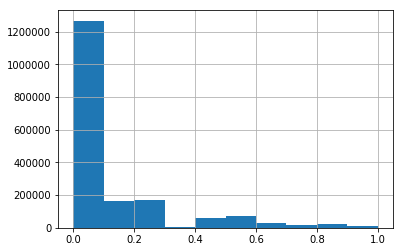

In [7]:
train_df.target.hist()

In [8]:
train_df.shape

(1804874, 3)

In [9]:
test_df.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [10]:
test_df.shape

(97320, 2)

In [11]:
# train_df = train_df.sample(100000, random_state=42)

In [12]:
train_df.shape

(100000, 3)

Create tokens

In [13]:
def tokenize(text):
    
    tokens = []
    for token in word_tokenize(text):
        if token in string.punctuation: continue
        if token in stop_words: continue
        tokens.append(stem.stem(token))
    
    return " ".join(tokens)

In [14]:
train_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in train_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 10275 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 30275 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 58275 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 94275 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100000 out of 100000 | elapsed:   54.4s finished


In [15]:
train_tokens[0]

'what breath fresh air someon embrac common sens valu instead leadership canada clear differ page perhap read differ book'

In [16]:
test_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in test_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 4536 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 28536 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 68536 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 97320 out of 97320 | elapsed:   47.0s finished


In [17]:
len(train_tokens + test_tokens)

197320

In [18]:
vect = TfidfVectorizer()
vect.fit(train_tokens + test_tokens)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
X = vect.transform(train_tokens)
y = train_df['target']

In [20]:
svr = LinearSVR(random_state=71, tol=1e-3, C=1.2)
svr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
test_X =  vect.transform(test_tokens)
test_y = svr.predict(test_X)

In [22]:
submisson_df = pd.read_csv("../input/sample_submission.csv")
submisson_df['prediction'] = test_y
submisson_df['prediction'] = submisson_df['prediction'].apply(lambda x: "%.5f" % x if x > 0 else 0.0)

In [23]:
submisson_df.to_csv("submission.csv", index=False)